In [1]:
!pkill thor_*
import ai2thor
from ai2thor.controller import Controller,BFSController
from ai2thor.platform import CloudRendering
from ithor_tools.vis_tool import *
from ithor_tools.transform import cornerpoint_projection
from ithor_tools.map2 import single_scenemap
from ithor_tools.landmark_utils import gather,vis_panorama,Word_Dict,choose_ladmark
import random
from co_occurance.move import co_occurance_based_schedular
import math
from IPython.display import display
from moviepy.editor import ImageSequenceClip,VideoFileClip


from co_occurance.comet_co import co_occurance_score
from co_occurance.move import co_occurance_based_schedular

"AI2-THOR Version: " + ai2thor.__version__

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


'AI2-THOR Version: 4.2.0'

## Setup

In [2]:
gridSize=0.05

controller = Controller(
    platform = CloudRendering,
    agentMode="locobot",
    visibilityDistance=5.0,
    scene = "FloorPlan_Train11_4",
    gridSize=gridSize,
    movementGaussianSigma=0,
    rotateStepDegrees=90,
    rotateGaussianSigma=0,
    renderDepthImage=False,
    renderInstanceSegmentation=False,
    width=300,
    height=300,
    fieldOfView=60
)


INFO - 2022-05-10 15:10:52,377 - controller - Initialize return: {'cameraNearPlane': 0.10000000149011612, 'cameraFarPlane': 20.0}


In [3]:
controller.reset(
    # makes the images a bit higher quality
    width=800,
    height=800,

    # Renders several new image modalities
    renderDepthImage=True,
    renderInstanceSegmentation=False,
    renderSemanticSegmentation=False,
    renderNormalsImage=False
)
scene_bounds = controller.last_event.metadata['sceneBounds']['center']
controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=5.0, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize= 5.0, fieldOfView=100,
    skyboxColor="white"
)
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']

controller.step(
    action="Teleport",
    position = rstate[100]
)

pos = controller.last_event.metadata['agent']['position']
pos = [pos['x'],pos['z']]
objects = controller.last_event.metadata['objects']

In [4]:
df = show_objects_table(objects)
df

Object Metadata. Not showing objectOrientedBoundingBox, axisAlignedBoundingBox, and receptacleObjectIds for clarity.


,objectType,objectId,name,position[x],position[y],position[z],rotation[x],rotation[y],rotation[z],distance,...,openness,pickupable,isPickedUp,moveable,mass,salientMaterials,assetId,parentReceptacles,controlledObjects,isMoving
0,Box,Box|+01.32|+00.24|-02.71,Box_12,1.3250,0.2405,-2.7123,-0.0024,0.0002,0.0005,2.1809,...,1.0,True,False,False,0.30,[Paper],Box_12,[Floor|+00.00|+00.00|+00.00],None,False
1,Statue,Statue|+09.25|+00.74|-02.78,Waving_Statue_2,9.2529,0.7415,-2.7845,0.0797,218.3742,0.0789,6.5747,...,0.0,True,False,False,1.00,[Stone],Waving_Statue_2,[DiningTable|+09.01|+00.00|-03.00],None,False
2,AlarmClock,AlarmClock|+01.28|+00.48|-04.63,Alarm_Clock_24,1.2837,0.4783,-4.6343,0.0372,59.9996,359.9423,3.7080,...,0.0,True,False,False,0.80,"[Metal, Plastic, Glass]",Alarm_Clock_24,"[SideTable|+01.23|+00.00|-04.66, Floor|+00.00|...",None,False
3,Bottle,Bottle|+08.37|+00.74|-03.32,Bottle_1,8.3749,0.7416,-3.3181,359.8950,0.1396,0.0138,5.8841,...,0.0,True,False,False,0.20,[Glass],Bottle_1,[DiningTable|+09.01|+00.00|-03.00],None,False
4,Laptop,Laptop|+01.71|+00.35|-01.61,Laptop_24,1.7094,0.3512,-1.6118,347.3698,120.3521,359.9577,1.3040,...,1.0,True,False,False,2.30,"[Metal, Plastic, Glass]",Laptop_24,"[ArmChair|+01.62|+00.00|-01.54, Floor|+00.00|+...",[],True
5,FloorLamp,FloorLamp|+04.23|00.00|-03.09,Floor_Lamp_21,4.2270,-0.0010,-3.0870,0.0055,0.0011,0.0060,2.4297,...,0.0,False,False,True,3.93,[Metal],Floor_Lamp_21,[Floor|+00.00|+00.00|+00.00],[],True
6,BasketBall,BasketBall|+01.13|+00.12|-04.34,Basketball_1,1.1323,0.1200,-4.3409,-0.0000,-0.0000,43.4934,3.5787,...,0.0,True,False,False,0.60,[Rubber],Basketball_1,[Floor|+00.00|+00.00|+00.00],None,False
7,BaseballBat,BaseballBat|+06.13|+00.68|-01.11,BaseballBat_2,6.1279,0.6817,-1.1069,349.2352,180.1768,179.9622,3.2908,...,0.0,True,False,False,0.90,[Wood],BaseballBat_2,[Floor|+00.00|+00.00|+00.00],None,False
8,RemoteControl,RemoteControl|+03.13|+00.40|-02.91,Remote_3,3.1119,0.3979,-2.9115,359.8602,153.6381,0.3845,1.7084,...,0.0,True,False,False,0.15,"[Metal, Plastic]",Remote_3,"[CoffeeTable|+02.43|+00.00|-02.78, Floor|+00.0...",None,True
9,SaltShaker,SaltShaker|+03.14|+00.40|-02.57,Salt_Shaker_2,3.1168,0.3957,-2.5760,0.1013,0.4527,359.6350,1.3981,...,0.0,True,False,False,0.60,"[Metal, Glass]",Salt_Shaker_2,"[CoffeeTable|+02.43|+00.00|-02.78, Floor|+00.0...",None,True


In [5]:
landmarks,visible_landmark_name = choose_ladmark(objects)
landmark_cat = [Word_Dict[l] for l in visible_landmark_name]

In [6]:
co_occurance_scoring = co_occurance_score(landmark_cat,'cuda:0')

model loading ...


INFO - 2022-05-10 15:10:59,607 - utils - using task specific params for summarization: {'early_stopping': True, 'length_penalty': 2.0, 'max_length': 24, 'min_length': 1, 'no_repeat_ngram_size': 3, 'num_beams': 4}


model loaded


In [7]:
scene_bounds = controller.last_event.metadata['sceneBounds']['cornerPoints']
scene_bounds = cornerpoint_projection(scene_bounds)

# query_object = random.choice(objects)
query_object = objects[8]
query_object_name = query_object['objectType']

print(query_object_name)


RemoteControl


## Co - occurance scoring

In [8]:
res = co_occurance_scoring.score(query_object_name)

0.6868000030517578 10.446799278259277 -5.351839542388916 0.5981607437133789
0
(418, 713, 4)


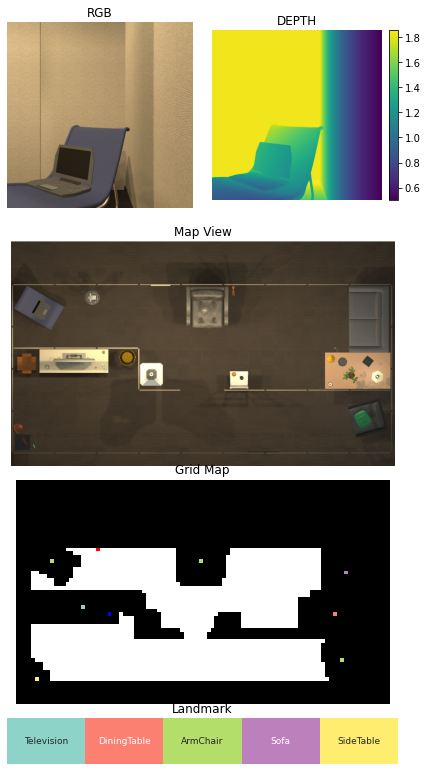

In [9]:
## Notice stepsize should be smaller than gridsize
stepsize = gridSize
sm = single_scenemap(scene_bounds,rstate,stepsize = 0.1,landmark_names=visible_landmark_name,landmarks=landmarks)
landmark_config = dict(name=visible_landmark_name,color = sm.landmark_colors)
imshow_grid = sm.plot(controller.last_event.metadata['agent']['position'],query_object['position'])
plot_frames(controller.last_event,imshow_grid,landmark_config)


In [10]:
thres = 0.3
schedular = co_occurance_based_schedular(landmarks,visible_landmark_name)
schedular.get_graph(sm,controller,res,thres)
print(schedular.node, schedular.edge)

[-1, 1.0, 0.587, 1.0, 0.67] [[0.         5.96459524 4.95309857 5.44946678 6.43778342]
 [5.96459524 0.         5.41480892 6.19126281 0.92973109]
 [4.95309857 5.41480892 0.         1.25299661 5.88799711]
 [5.44946678 6.19126281 1.25299661 0.         6.664451  ]
 [6.43778342 0.92973109 5.88799711 6.664451   0.        ]]


In [11]:
path = schedular.optimize()
path

[0, 1, 3, 2, 4]


[({'x': 2.8499999046325684, 'y': 0.9009997248649597, 'z': -1.2999999523162842},
  0),
 [{'x': 2.4000000000000004, 'y': 0.91, 'z': -3.8000000000000007}, 0, 1.0],
 [{'x': 8.1, 'y': 0.91, 'z': -1.9000000000000004}, 90, 1.0],
 [{'x': 7.500000000000001, 'y': 0.91, 'z': -3.0000000000000004}, 90, 0.587],
 [{'x': 2.1, 'y': 0.91, 'z': -4.700000000000001}, 270, 0.67]]

NameError: name 'w' is not defined

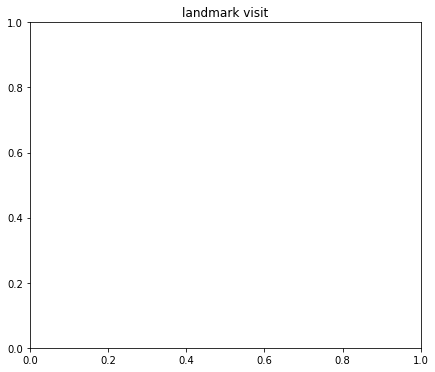

In [12]:
vis_visit_landmark(query_object,path,controller,sm,landmark_config)

## Teleport to Landmark

True
(418, 713, 4)


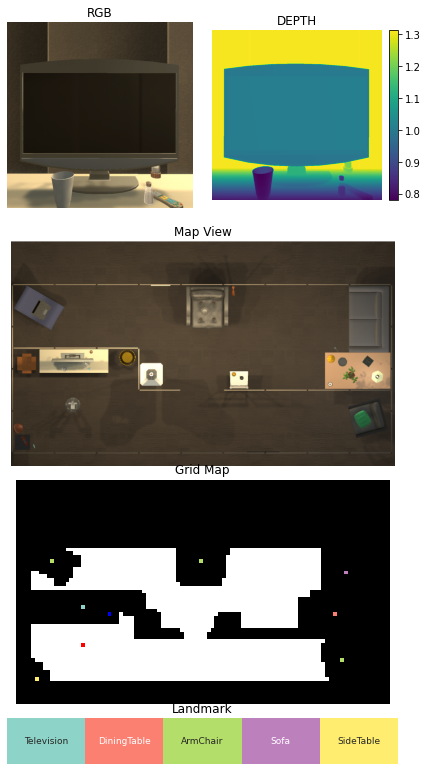

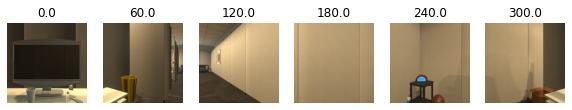

In [ ]:
controller.step(
    action="Teleport",
    position = rstate[100]
)

for p in path[1:]:
    controller.step(action="Teleport",
                    position = p[0], rotation = dict(x=0,y=p[1],z=0))
    pos = controller.last_event.metadata['agent']['position']
    print(controller.last_event.metadata['lastActionSuccess'])    
    imshow_grid = sm.plot(pos,query_object['position'])
    plot_frames(controller.last_event,imshow_grid,landmark_config)
    frames, vis = gather(controller,query_object['objectType'],step=6)
    vis_panorama(frames)
    if vis:
        break

## RRT 

In [ ]:
controller.step(
    action="Teleport",
    position = rstate[100]
)


<ai2thor.server.Event at 0x7ff7f007c610
    .metadata["lastAction"] = Teleport
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [ ]:
from RRT import gridmaprrt as rrt
from RRT import gridmaprrt_pathsmoothing as smoothing
from IPython.display import Image as IM

In [ ]:
rrtplanner = rrt.RRT(controller = controller, expand_dis=0.1,max_iter=10000,goal_sample_rate=20)

[{'x': 2.4000000000000004, 'y': 0.91, 'z': -3.8000000000000007}, 0, 1.0]
start planning
path found!
end planning


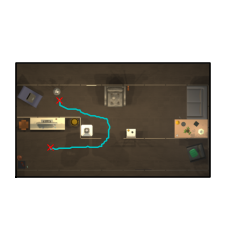

(418, 713, 4)


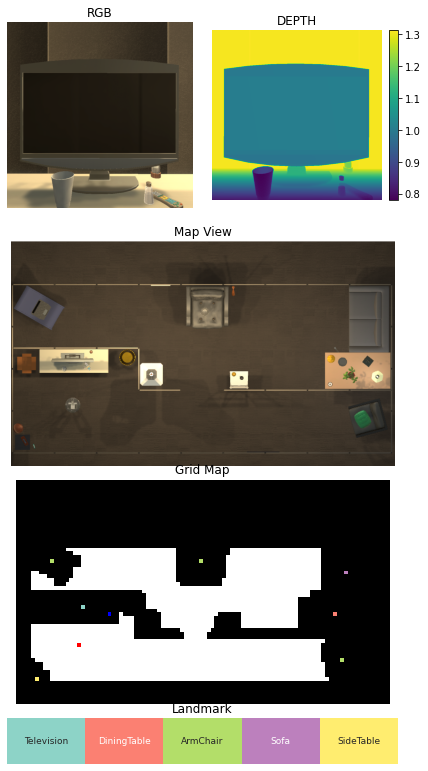

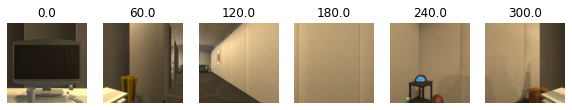

In [ ]:
controller.step(
    action="Teleport",
    position = rstate[100]
)
for p in path[1:]:
    print(p)
    pos = controller.last_event.metadata['agent']['position']
    rrtplanner.set_start(pos)
    rrtplanner.set_goal(p[0])
    print("start planning")
    local_path = rrtplanner.planning(animation=False)
    smoothpath = smoothing.path_smoothing(rrtplanner,40,verbose=False)
    print("end planning")
    rrtplanner.plot_path(smoothpath)
    
    flag,frames = rrtplanner.go_with_teleport(smoothpath,maxspeed=0.2)
    # video = ImageSequenceClip(frames, fps=10)
    # video.write_gif('temp.gif')
    # with open('temp.gif','rb') as file:
    #     display(IM(file.read(),width = 300))
    
    pos = controller.last_event.metadata['agent']['position']
    controller.step(
        action="Teleport",
        position = pos, rotation = dict(x=0,y=p[1],z=0)
            )
    imshow_grid = sm.plot(pos,query_object['position'])
    plot_frames(controller.last_event,imshow_grid,landmark_config)
    frames, vis = gather(controller,query_object['objectType'],step=6)
    vis_panorama(frames)
    if vis:
        break